# 1 Author

**Student Name**:  Yuchen Fan

**Student ID**:  210977729


# 2 Problem formulation

**1. Conducting unsupervised learning to classify whether smiling or not**

Since there are not many well-annotated data, most of our machine learning work will focus on unannotated data. Therefore, we need to do unsupervised learning. I want to find out the results and ways to improve the performance.

**2. Conducting semi-supervised learning to classify whether smiling or not**

To provide some data points as guideline for unsupervised learning, we need manually or make use of SOTA models to annotate. That is semi-supervised learning. I want to get familiar with the pipeline and find out to what extent will semi-supervied learning improve the performance.

**3. Understanding the underlying structure of the dataste using unsupervised learning**

By using brute-force, we can use DBSCAN and K-Means, iterating paratermers and least-sample-numbers in DBSCAN and number of clusters in K-Means to find the regularity and underlying patters.

**NOTE**

For classification task, I use F1-Score and Accuracy as the evaluation metric. Higher the F1-Score and Accuracy, better the performance.

For Finding out underlying patterns, I use several metrics such as Silhouette Score, Davies-Bouldin Index and Calinski-Harabasz Index. The closer Silhouette Score is to 1, the better the performance. The smaller Davies-Bouldin Index is, the better the performance. The larger Calinski-Harabasz Index is, the better the performance.

# 3 Machine Learning pipeline

The pipeline is:

Load data -> Preprocess data -> Transform data -> Unsupervised learning or semi-supervised learning -> evaluate the results.

For **Load data:**

Input is file path, output is an array containing all the images and labels.

For **Preprocess data and Transform data:**

Input is an image array, output is a feature matrix generated by ResNet50. Its dimension is reduced by using PCA.

For **Unsupervised learning or semi-supervised learning:**

Input is a feature matrix, output is a classifier.

# 4 Transformation stage

For a picture, what matters is the order of the pixeds and the value of each pixel. In my procession, I normalize the values of pixels to 0 - 1 and randomly drop some pixels.

By using transformation, the effectiveness and robustness of the model will be improved a lot, overfitting will be avoided.

The implementation are as follows

In [1]:
from torchvision.transforms import transforms
from PIL import Image

# Preprocess image to be compatible with the model and improve robustness
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'))
    # using resize, centercrop and totensor to match the model's input dimensions
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)
    return image

What's more, to progress in unsupervised learning or semi-supervised learning, we should identify and understand the underlying structure of the dataset, requring us to extract features.

There are many ways to extract features, for instance, using the original pixels, normalization and so on. The most effective way is using a pre-trained model because of its ability to do understream works withou fine-tuning. Besides, it gets acess to thousands of data, thus better for feature extraction.

Below are my implementation:

In [2]:
import torch
import numpy as np

# Extract features from a dataset using a model
def feature_extraction(model,dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    all_features = []
    for image, label in dataset:
        image = preprocess_image(image).to(device)
        with torch.no_grad():
            features = model(image)
            features_np = features.squeeze().cpu().numpy()
            all_features.append(features_np)
    all_features_np = np.array(all_features)
    return all_features_np


# 5 Modelling

In this section, I use the ResNet series, e.g. ResNet18, ResNet34, ResNet50 along with CNN for feature extraction.

On one hand, we can find the feature extraction performance as the depth of the neural network increases.

On another, we can compare between different architectures, e.g. residual connection and simple connection.

My implementaion of modeling is as follows:

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# The initial CNN used for the experiments
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 56 * 56, 128) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
from torchvision import models
import torch

# Models used for the experiments
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1])) 
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1])) 
resnet34 = models.resnet34(pretrained=True)
resnet34 = torch.nn.Sequential(*(list(resnet34.children())[:-1]))
cnn = CNN(2)

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weight

# 6 Methodology

For **Unsupervised Learning:**

Firstly I normalize all features to reduce calculation. Then I use K-means algorithm to make clusters. Finally, I use PCA plot and confusiton matrix along with clasification_report for assession.

Afterwards, I tried to find out the patterns underlying the dataset. I use two methods seperately, e.g. DBSCAN and K-Means.

The implementation is as follows:


In [5]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def flatten_images(X):
    return X.reshape(X.shape[0], -1)

# Cluster the features extracted from the dataset using KMeans
def cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(X_train_flat)

    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(features_scaled)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features_scaled)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('Cluster Visualization')
    plt.show()
    X_val_scaled = scaler.transform(X_val_flat)
    y_val_pred = kmeans.predict(X_val_scaled)
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))


In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Cluster the features extracted from the dataset using DBSCAN
def cluster_with_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    if len(set(labels)) == 1 and labels[0] == -1:
        return -1, -1, -1

    if len(set(labels)) - (1 if -1 in labels else 0) == 1:
        return -1, -1, -1

    # 计算各种评分
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    davies_bouldin = davies_bouldin_score(X, labels) if silhouette != -1 else -1
    calinski_harabasz = calinski_harabasz_score(X, labels) if silhouette != -1 else -1

    return silhouette, davies_bouldin, calinski_harabasz

# Find the optimal parameters for DBSCAN
def find_optimal_params(X, eps_values, min_samples_values):
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    all_scores = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            silhouette, davies_bouldin, calinski_harabasz = cluster_with_dbscan(X, eps, min_samples)
            all_scores.append((eps, min_samples, silhouette, davies_bouldin, calinski_harabasz))

            if silhouette > best_score:
                best_score = silhouette
                best_params = {'eps': eps, 'min_samples': min_samples}

    return best_params, best_score, all_scores


In [20]:
# Cluster the features extracted from the dataset using KMeans
def cluster_with_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)

    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)

    return silhouette, davies_bouldin, calinski_harabasz

# Find the optimal number of clusters for KMeans
def find_optimal_k(X, k_values):
    scores = []
    for k in k_values:
        silhouette, davies_bouldin, calinski_harabasz = cluster_with_kmeans(X, k)
        scores.append((k, silhouette, davies_bouldin, calinski_harabasz))
        print(f"k={k}: Silhouette={silhouette:.2f}, Davies-Bouldin={davies_bouldin:.2f}, Calinski-Harabasz={calinski_harabasz:.2f}")
    return scores


For **Semi-supervised Learning:**

Firstly I use random library to find some guidance for unsupervised part. After that, I normalize all features to reduce calculation. Then I use K-means algorithm to make clusters. Finally, I use PCA plot and confusiton matrix along with clasification_report for assession.

The implementation is as follows:

In [7]:
from sklearn.cluster import KMeans
import numpy as np
from random import randint
from sklearn.metrics import confusion_matrix, classification_report

# Cluster the features extracted from the dataset using KMeans and use the labels to train a classifier
def cluster_features_semi(X_train, y_train, X_val, y_val, k=2, n=1000):
    cnt = 0
    labeled_indices = []
    while cnt < n:
        idx = randint(0, len(X_train)-1)
        if idx not in labeled_indices:
            labeled_indices.append(idx)
            cnt += 1
            
    scaler = StandardScaler()
    
    features_scaled = scaler.fit_transform(X_train)
            
    labeled_features = X_train[labeled_indices]
    labeled_labels = y_train[labeled_indices]

    unique_labels = np.unique(labeled_labels)
    initial_centers = [labeled_features[labeled_labels == label].mean(axis=0) for label in unique_labels]

    kmeans = KMeans(n_clusters=len(unique_labels), init=np.vstack(initial_centers), n_init=1)
    kmeans.fit(X_train)

    pca = PCA(n_components=k)
    reduced_features = pca.fit_transform(features_scaled)
    
    clusters = kmeans.predict(features_scaled)

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('Cluster Visualization')
    plt.show()
    
    y_val_pred = kmeans.predict(X_val)
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))

# 7 Dataset

At first, I read in the images and labels, making them a dataset.

Then as mentioned above, I did some preprocess, for instance, normalization, dropping pixels, flipping, ratation and so on.

In [12]:
'''
load dataset
'''

import cv2
import os
from sklearn.model_selection import train_test_split

# Load the dataset 
def load_dataset(model):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    root = "Your path here"
    predictors = []

    classification_labels = []
    detection_labels = []
    with open("Your path here") as f:
        for line in f.readlines():
            classification_labels.append(int(line[0]))
            line = line[2:].split()
            detection_labels.append((float(line[0]), float(line[1]), float(line[2])))
            
    for i in range(len(detection_labels)):
        detection_label = detection_labels[i]
        classification_label = classification_labels[i]
        filename = f'{root}/file{str(i+1).zfill(4)}.jpg'
        img = cv2.imread(filename)
        img = cv2.resize(img, (256, 256))
        predictors.append(img)

    classification_dataset = []
    for i in range(len(classification_labels)):
        classification_dataset.append((predictors[i], classification_labels[i]))
        
    detection_dataset = []
    for i in range(len(detection_labels)):
        detection_dataset.append((predictors[i], detection_labels[i]))

    all_features_np = feature_extraction(model, classification_dataset)
    all_labels = np.array(classification_labels)

    X_train, X_val, y_train, y_val = train_test_split(all_features_np, all_labels, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

    

# 8 Results

### Classification:

For **Unsupervised Learning:**

We compare the results of the same architecture with different depth and different architecture.


The results of using ResNet50 are as follow:

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


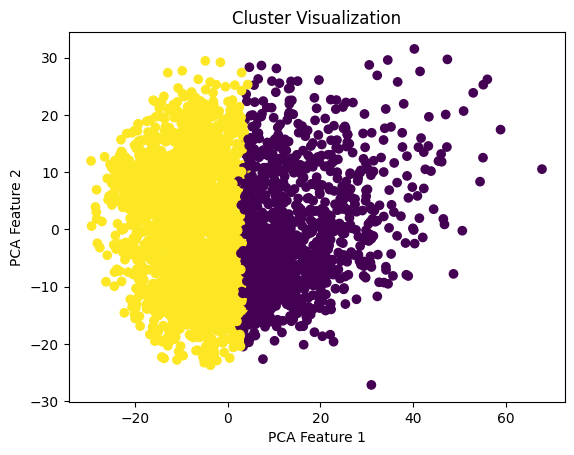

[[150 204]
 [124 322]]
              precision    recall  f1-score   support

           0       0.55      0.42      0.48       354
           1       0.61      0.72      0.66       446

    accuracy                           0.59       800
   macro avg       0.58      0.57      0.57       800
weighted avg       0.58      0.59      0.58       800



In [60]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

The results of using ResNet34 are as follow:

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


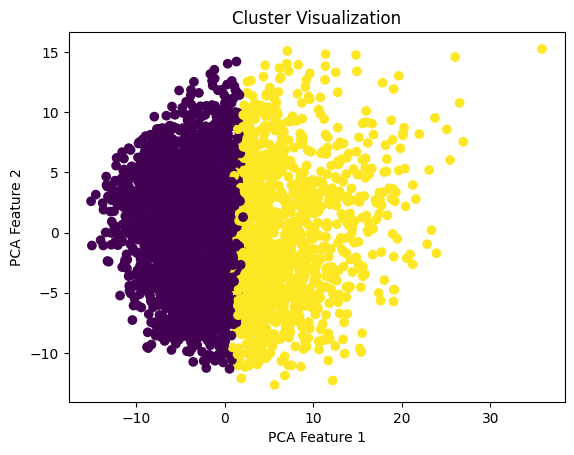

[[187 167]
 [323 123]]
              precision    recall  f1-score   support

           0       0.37      0.53      0.43       354
           1       0.42      0.28      0.33       446

    accuracy                           0.39       800
   macro avg       0.40      0.40      0.38       800
weighted avg       0.40      0.39      0.38       800



In [63]:
X_train, X_val, y_train, y_val = load_dataset(resnet34)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

The results of using ResNet18 are as follow:

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


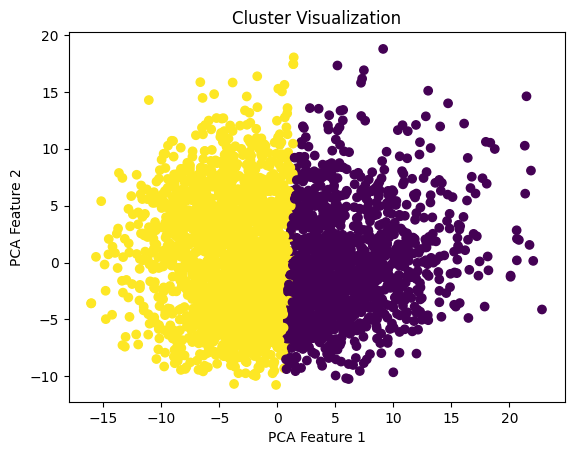

[[177 177]
 [139 307]]
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       354
           1       0.63      0.69      0.66       446

    accuracy                           0.60       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.60      0.60      0.60       800



In [64]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

The results of using CNN are as follow:

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


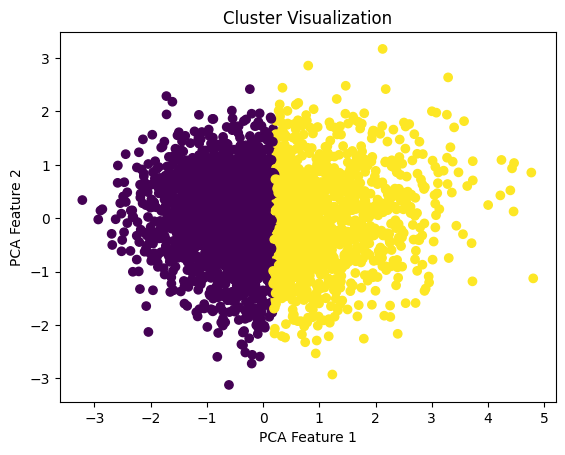

[[216 138]
 [268 178]]
              precision    recall  f1-score   support

           0       0.45      0.61      0.52       354
           1       0.56      0.40      0.47       446

    accuracy                           0.49       800
   macro avg       0.50      0.50      0.49       800
weighted avg       0.51      0.49      0.49       800



In [75]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

For **Semi-supervised Learning:**

We compare the performance of the same model with different guidance points and the performance of the same guidance points with different models.

The results of using ResNet18 with *n=200* are as follow:

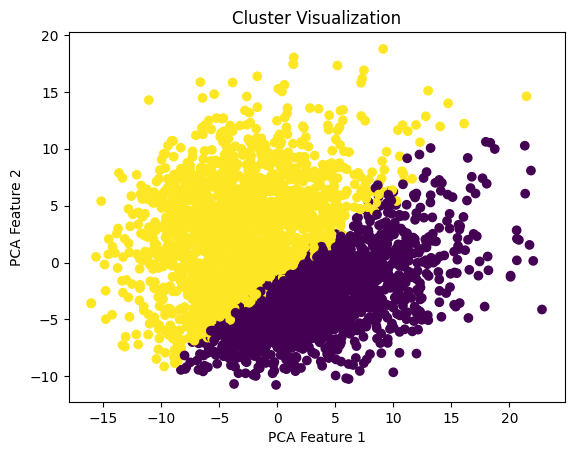

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800



In [65]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

The results of using ResNet18 with *n=500* are as follow:

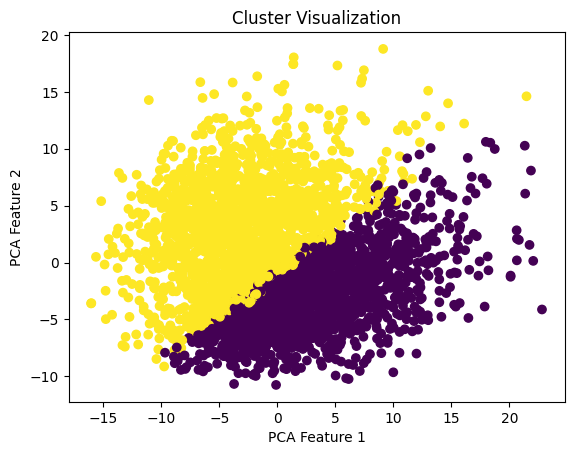

[[264  90]
 [213 233]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       354
           1       0.72      0.52      0.61       446

    accuracy                           0.62       800
   macro avg       0.64      0.63      0.62       800
weighted avg       0.65      0.62      0.62       800



In [66]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

The results of using ResNet18 with *n=1000* are as follow:

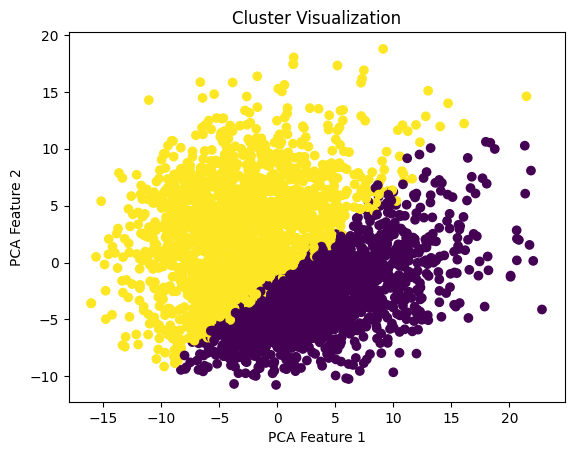

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800



In [67]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

The results of using ResNet50 with *n=200* are as follow:

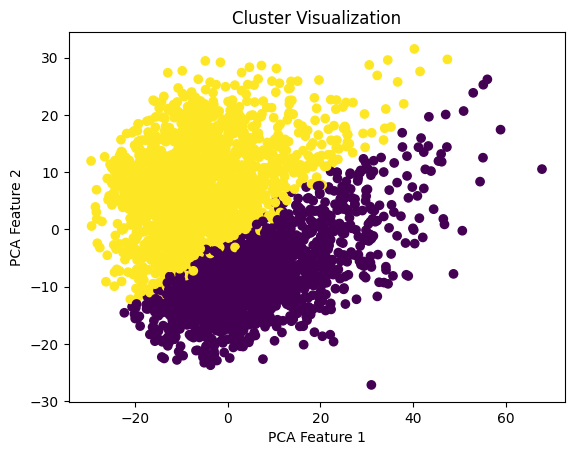

[[261  93]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [70]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

The results of using ResNet50 with *n=500* are as follow:

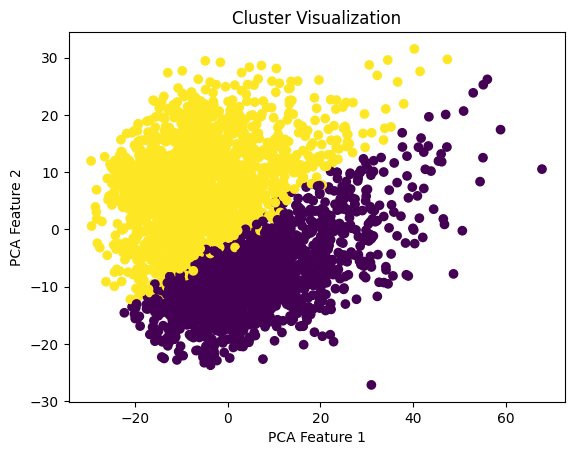

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [71]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

The results of using ResNet50 with *n=1000* are as follow:

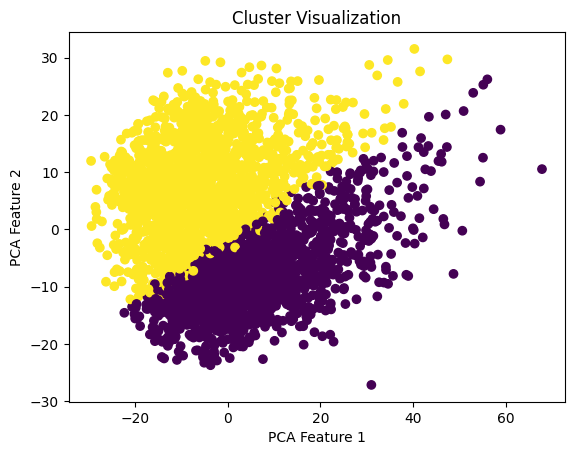

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800



In [72]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

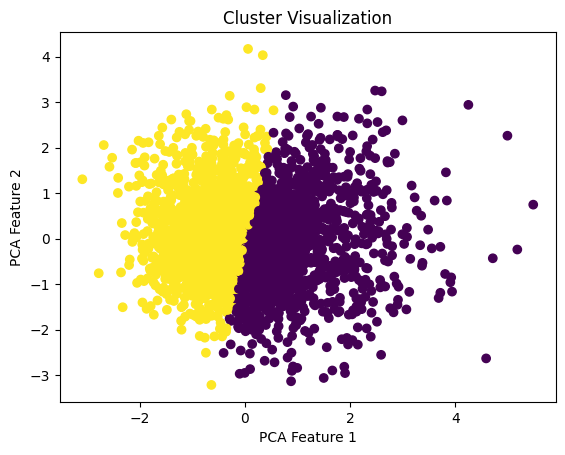

[[133 221]
 [172 274]]
              precision    recall  f1-score   support

           0       0.44      0.38      0.40       354
           1       0.55      0.61      0.58       446

    accuracy                           0.51       800
   macro avg       0.49      0.50      0.49       800
weighted avg       0.50      0.51      0.50       800



In [14]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

/Users/apple/miniconda3/envs/fdu-nlp/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


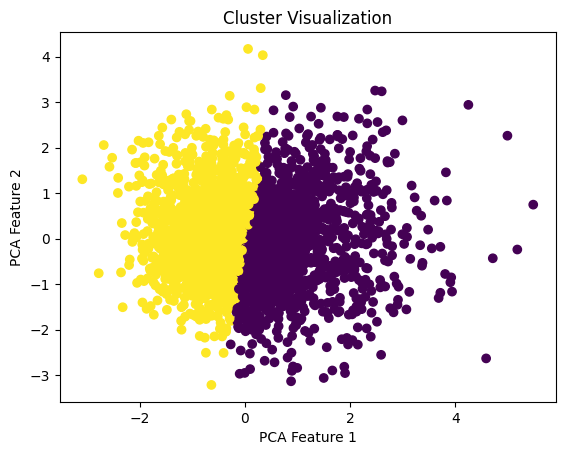

[[132 222]
 [172 274]]
              precision    recall  f1-score   support

           0       0.43      0.37      0.40       354
           1       0.55      0.61      0.58       446

    accuracy                           0.51       800
   macro avg       0.49      0.49      0.49       800
weighted avg       0.50      0.51      0.50       800



In [13]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

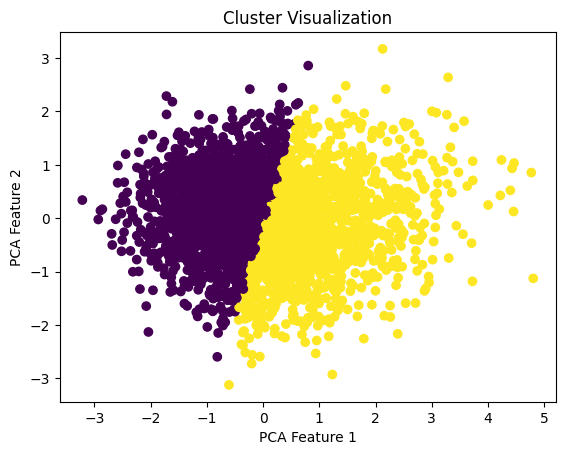

[[213 141]
 [267 179]]
              precision    recall  f1-score   support

           0       0.44      0.60      0.51       354
           1       0.56      0.40      0.47       446

    accuracy                           0.49       800
   macro avg       0.50      0.50      0.49       800
weighted avg       0.51      0.49      0.49       800



In [80]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

For **Unsupervised Learning:**:

I find that ResNet18 achieves the best performance, the next is ResNet50 and CNN. To my surprise, ResNet34 perform worse than CNN. 

For **Semi-supervised Learning:**:

I find that all classifiers perform better compared with unsupervised learning situation. Howeverm when I increase the number of guidance points, the performance does not improve a lot.

### Finding Patterns:

Specifically, I use K-Means and DBSCAN to cluster.

The results of clustering using DBSCAN are as follows:

In [27]:
X_train, X_val, _ , _ = load_dataset(resnet)
X_train_flat = flatten_images(X_train)

eps_values = np.arange(0.1, 5, 0.1)
min_samples_values = range(2, 10)

best_params, best_score, all_scores = find_optimal_params(X_train_flat, eps_values, min_samples_values)

print("best_parameters:", best_params)
print("best_score:", best_score)

for score in all_scores:
    print("EPS:", score[0], "Min_samples:", score[1], 
          "Silhouette:", score[2], "Davies-Bouldin:", score[3], 
          "Calinski-Harabasz:", score[4])

best_parameters: {'eps': 0.1, 'min_samples': 2}
best_score: -0.17397228
EPS: 0.1 Min_samples: 2 Silhouette: -0.17397228 Davies-Bouldin: 1.0501759100145036 Calinski-Harabasz: 1.8831723400102067
EPS: 0.1 Min_samples: 3 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.1 Min_samples: 4 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.1 Min_samples: 5 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.1 Min_samples: 6 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.1 Min_samples: 7 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.1 Min_samples: 8 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.1 Min_samples: 9 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.2 Min_samples: 2 Silhouette: -0.17397228 Davies-Bouldin: 1.0501759100145036 Calinski-Harabasz: 1.8831723400102067
EPS: 0.2 Min_samples: 3 Silhouette: -1 Davies-Bouldin: -1 Calinski-Harabasz: -1
EPS: 0.2 Min_samples: 4 Silhouette: -1 Davies-

By obeserving the information above:

We can conclude that using eps == 0.1 and min_samples == 2 we can get the best results.

The results of clustering using K-Means are as follows:

c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=2: Silhouette=0.08, Davies-Bouldin=3.24, Calinski-Harabasz=351.13


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=3: Silhouette=0.06, Davies-Bouldin=3.70, Calinski-Harabasz=256.42


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=4: Silhouette=0.05, Davies-Bouldin=3.52, Calinski-Harabasz=209.17


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=5: Silhouette=0.05, Davies-Bouldin=3.56, Calinski-Harabasz=175.37


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=6: Silhouette=0.03, Davies-Bouldin=3.62, Calinski-Harabasz=154.31


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=7: Silhouette=0.02, Davies-Bouldin=3.76, Calinski-Harabasz=139.80


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=8: Silhouette=0.02, Davies-Bouldin=3.74, Calinski-Harabasz=127.96


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=9: Silhouette=0.02, Davies-Bouldin=3.54, Calinski-Harabasz=118.33


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=10: Silhouette=0.02, Davies-Bouldin=3.55, Calinski-Harabasz=110.34


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=11: Silhouette=0.01, Davies-Bouldin=3.49, Calinski-Harabasz=103.70


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=12: Silhouette=0.01, Davies-Bouldin=3.62, Calinski-Harabasz=97.28


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=13: Silhouette=0.01, Davies-Bouldin=3.62, Calinski-Harabasz=91.96


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=14: Silhouette=0.01, Davies-Bouldin=3.50, Calinski-Harabasz=87.01


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=15: Silhouette=0.01, Davies-Bouldin=3.55, Calinski-Harabasz=83.06


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=16: Silhouette=0.01, Davies-Bouldin=3.56, Calinski-Harabasz=79.34


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=17: Silhouette=0.00, Davies-Bouldin=3.49, Calinski-Harabasz=75.95


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=18: Silhouette=0.01, Davies-Bouldin=3.51, Calinski-Harabasz=72.84


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=19: Silhouette=0.01, Davies-Bouldin=3.54, Calinski-Harabasz=70.20


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=20: Silhouette=0.01, Davies-Bouldin=3.56, Calinski-Harabasz=67.61


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=21: Silhouette=0.00, Davies-Bouldin=3.59, Calinski-Harabasz=65.16


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=22: Silhouette=0.00, Davies-Bouldin=3.53, Calinski-Harabasz=63.15


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=23: Silhouette=0.01, Davies-Bouldin=3.58, Calinski-Harabasz=60.86


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=24: Silhouette=0.00, Davies-Bouldin=3.59, Calinski-Harabasz=59.11


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=25: Silhouette=0.01, Davies-Bouldin=3.54, Calinski-Harabasz=57.42


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=26: Silhouette=0.00, Davies-Bouldin=3.65, Calinski-Harabasz=55.55


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=27: Silhouette=0.01, Davies-Bouldin=3.56, Calinski-Harabasz=54.09


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=28: Silhouette=0.00, Davies-Bouldin=3.54, Calinski-Harabasz=52.88


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=29: Silhouette=0.00, Davies-Bouldin=3.54, Calinski-Harabasz=51.01


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=30: Silhouette=0.00, Davies-Bouldin=3.54, Calinski-Harabasz=50.31


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=31: Silhouette=0.00, Davies-Bouldin=3.49, Calinski-Harabasz=49.00


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=32: Silhouette=-0.00, Davies-Bouldin=3.47, Calinski-Harabasz=48.05


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=33: Silhouette=0.00, Davies-Bouldin=3.57, Calinski-Harabasz=46.53


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=34: Silhouette=-0.00, Davies-Bouldin=3.53, Calinski-Harabasz=45.88


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=35: Silhouette=-0.00, Davies-Bouldin=3.57, Calinski-Harabasz=44.69


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=36: Silhouette=0.00, Davies-Bouldin=3.51, Calinski-Harabasz=43.66


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=37: Silhouette=-0.00, Davies-Bouldin=3.55, Calinski-Harabasz=42.74


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=38: Silhouette=0.00, Davies-Bouldin=3.54, Calinski-Harabasz=42.23


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=39: Silhouette=-0.00, Davies-Bouldin=3.46, Calinski-Harabasz=41.41


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=40: Silhouette=-0.00, Davies-Bouldin=3.51, Calinski-Harabasz=40.48


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=41: Silhouette=0.00, Davies-Bouldin=3.40, Calinski-Harabasz=39.68


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=42: Silhouette=-0.00, Davies-Bouldin=3.45, Calinski-Harabasz=39.25


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=43: Silhouette=0.00, Davies-Bouldin=3.48, Calinski-Harabasz=38.67


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=44: Silhouette=-0.00, Davies-Bouldin=3.46, Calinski-Harabasz=37.81


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=45: Silhouette=-0.00, Davies-Bouldin=3.46, Calinski-Harabasz=37.09


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=46: Silhouette=-0.00, Davies-Bouldin=3.48, Calinski-Harabasz=36.46


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=47: Silhouette=-0.00, Davies-Bouldin=3.46, Calinski-Harabasz=35.90


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=48: Silhouette=-0.00, Davies-Bouldin=3.54, Calinski-Harabasz=35.37


c:\Users\yuche\miniconda3\envs\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=49: Silhouette=-0.00, Davies-Bouldin=3.39, Calinski-Harabasz=34.80


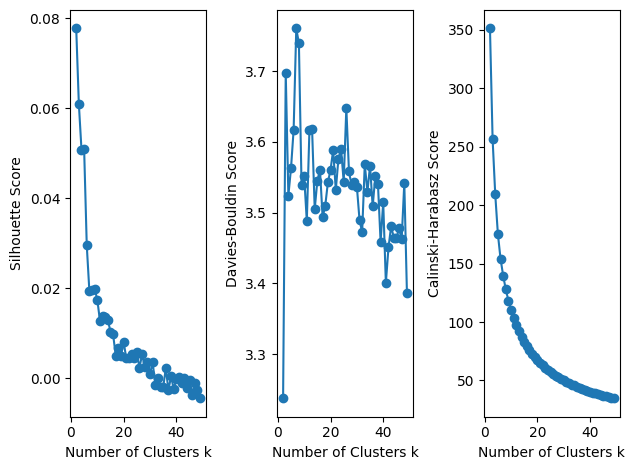

In [25]:
X_train, X_val, _, _ = load_dataset(resnet)
new_X = np.concatenate((X_train, X_val), axis=0)
X = flatten_images(new_X)

k_values = range(2, 50)

scores = find_optimal_k(X, k_values)

silhouettes = [score[1] for score in scores]
davies_bouldins = [score[2] for score in scores]
calinski_harabaszs = [score[3] for score in scores]
k_list = list(k_values)

plt.subplot(1, 3, 1)
plt.plot(k_list, silhouettes, marker='o')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_list, davies_bouldins, marker='o')
plt.xlabel('Number of Clusters k')
plt.ylabel('Davies-Bouldin Score')

plt.subplot(1, 3, 3)
plt.plot(k_list, calinski_harabaszs, marker='o')
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

By observing the three plots above, we can find that:

With the increase of the number of clusters, the Silhouette Score, Davies-Bouldin Index and Calinski-Harabasz Index are decreasing marginally, which indicates that the performance of the clustering model change from overfitting to underfitting, corresponding to what we have learnt in our class. Moreover, when k equals to 2, the performance is best. However, the 2 cluster cannot be used to determine whether the image is smiling or not due to the poor performance above. Therefore, we can infer that the two clusters may be split based on their sex and so on.

# 9 Conclusions

### Conclusions:

1. Compared with a simple network, pretrained models can better extract the features due to their trained paramters during pre-training stage.

2. For a simple task like 0 - 1 classification, increasing the depth of the neural network may not improve the performance. In contrast, the performance may drop due to overfitting and model degration.

3. Semi-supervised classifier perform always better than unsupervised classifier, due to the cluster centers have been determined in the beginning.

4. Increasing the number of semi-supervised points at least will not drop the accuracy of the classifier, but it is hard to say whether its performance will be improved.

5. Neither unsupervised learning nor semi-supervised learning perform better than supervised learning, which corresponds to our intuitivity.

6. Unsupervised learning of some models even behave worse than random guess, indicating that the dataset has more complex underlying structure rather than 0-1 distribution which is intuitively correct.

### Improvements:

1. Use ResNet for feature extraction, performing better than not-pre-trained model.

2. Comparing the performance of semi-supervised learning and unsupervised learning, along with supervised learning.

### Future Work:

1. Use more strong models for feature extraction.

2. Manually select high-quality data points for semi-supervised learning to observe the correlation between the data quality and the performance of semi-supervised learning.

# Notice

For more information, please refer to my github repo:

https://github.com/YuchenFan48/Project-ML